In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 3a
commitnumber = d5931a1
conc = 0.0004
dv = 0.001
klin = 6.375563e-24
molecule = co2
ng_adju = [0, 0, 0]
ng_refs = [3, 2, 4]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 300
vmax = 620
vmin = 540
w_diffuse = [(1.6, 1.6, 1.7), (1.75, 1.75), (1.55, 1.55, 1.6, 1.85)]
wgt = [(0.7, 0.3, 0.7), (0.7, 0.6), (0.4, 0.5, 0.8, 0.95)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

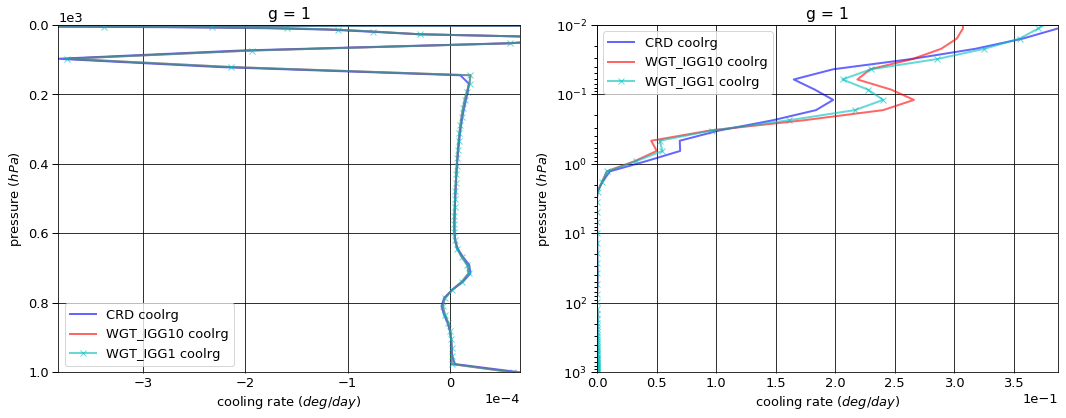

# Figure: cooling rate g-group 2

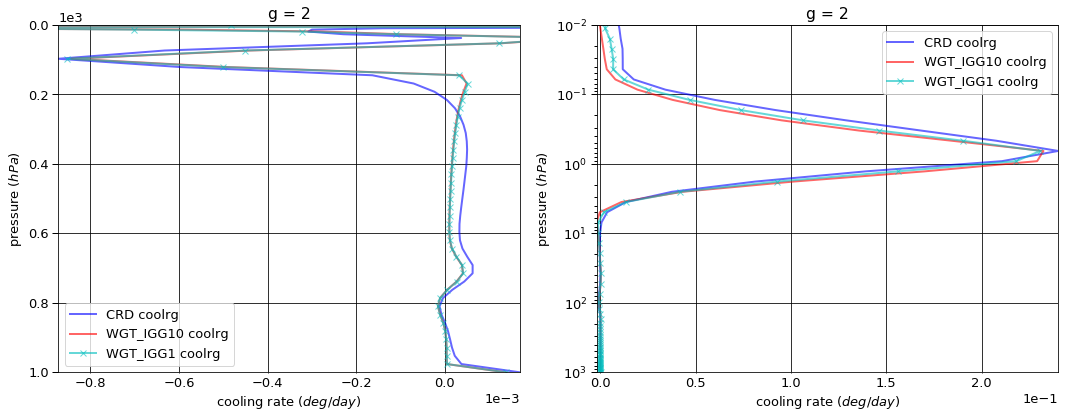

# Figure: cooling rate g-group 3

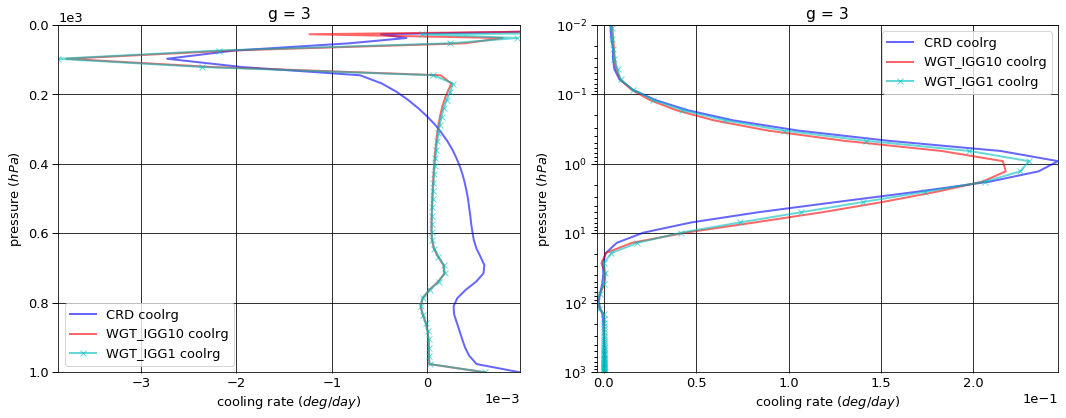

# Figure: cooling rate g-group 4

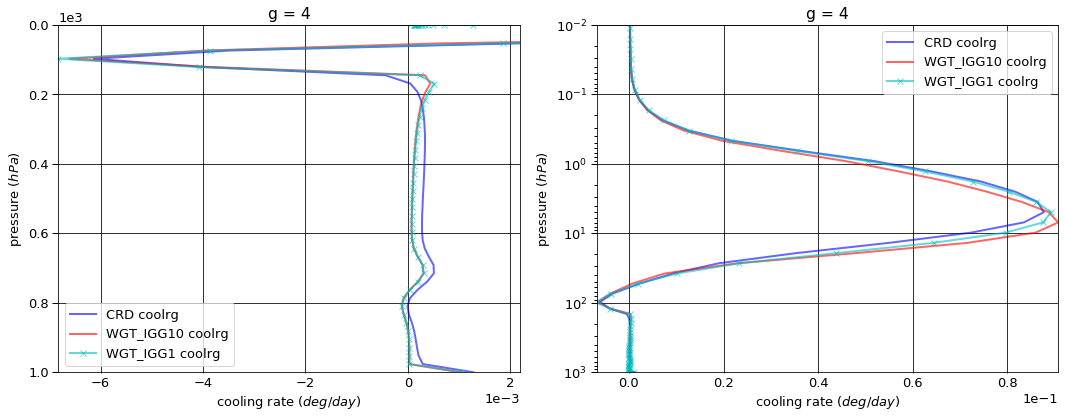

# Figure: cooling rate g-group 5

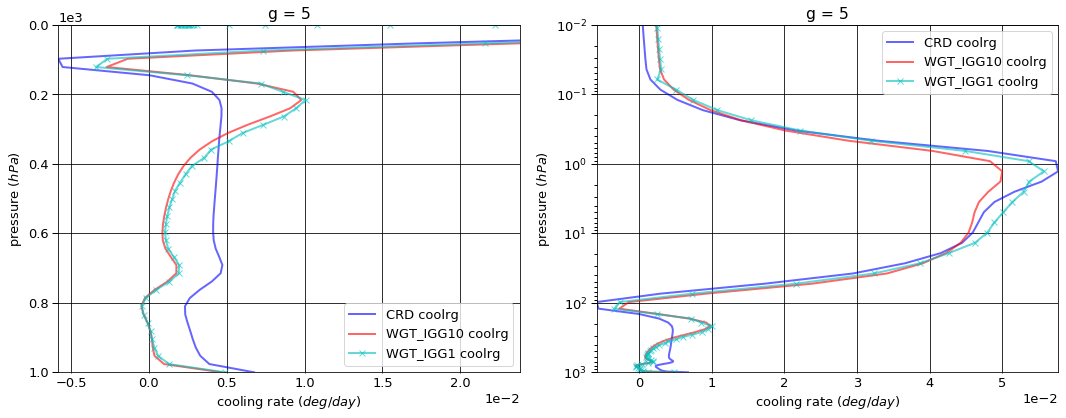

# Figure: cooling rate g-group 6

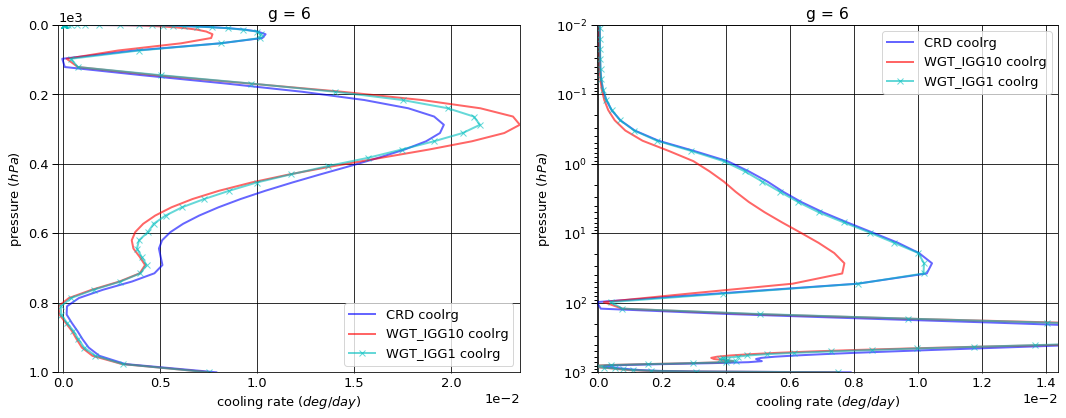

# Figure: cooling rate g-group 7

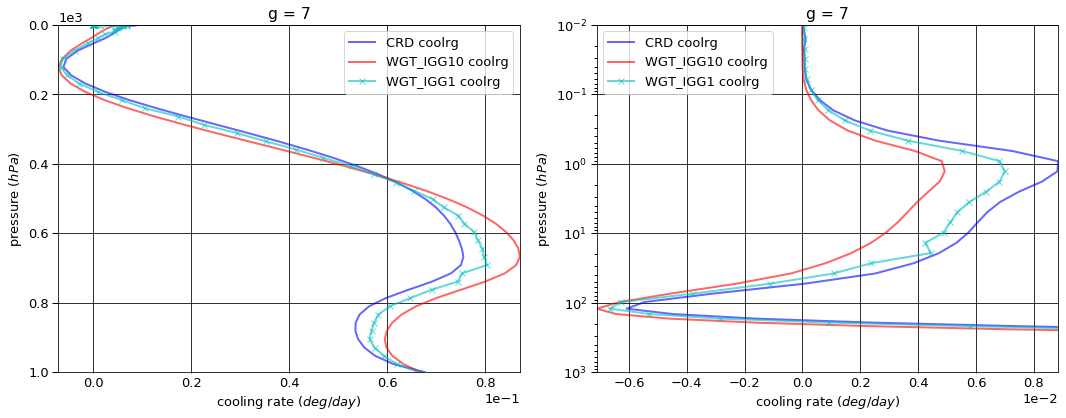

# Figure: cooling rate g-group 8

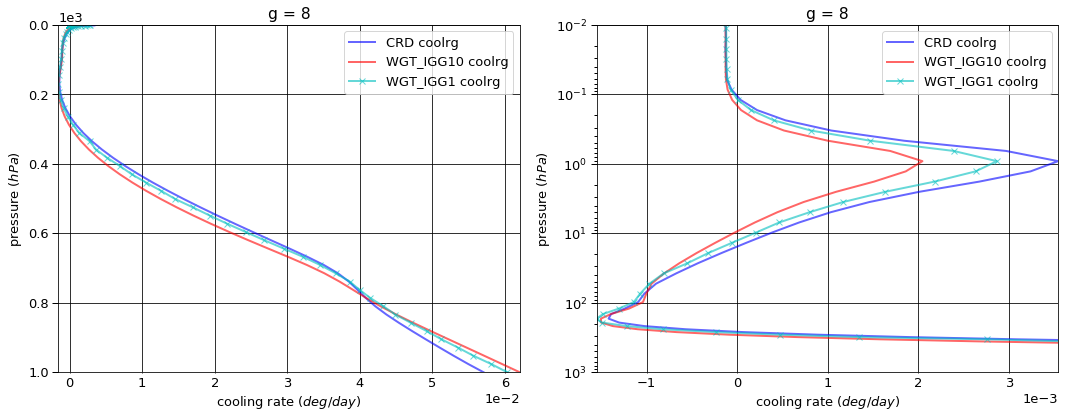

# Figure: cooling rate g-group 9

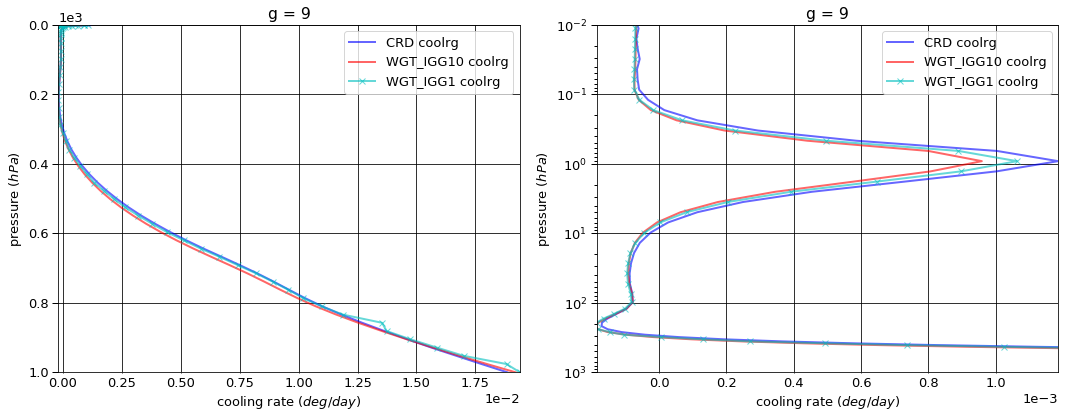

# Figure: cooling rate g-group total

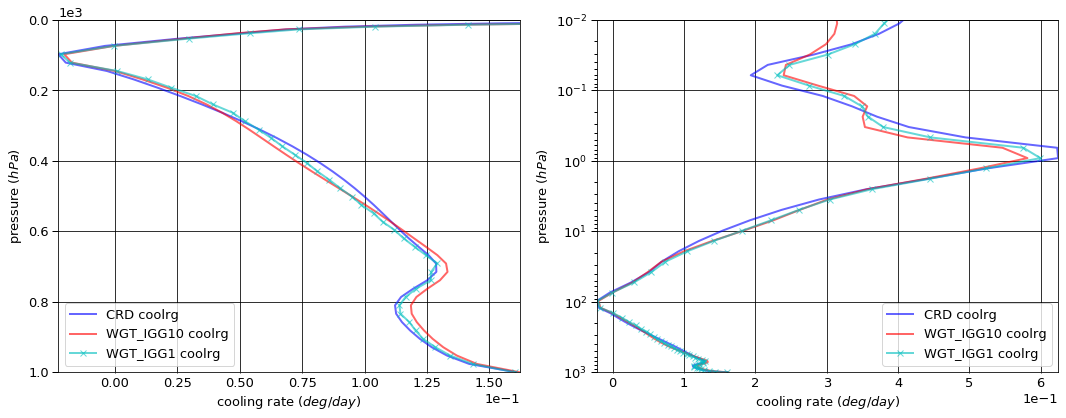

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.011853  0.000000  -0.011853
  1013.0   76     -0.028390  0.028189  -0.000201
2 0.0      1      -0.038079  0.000000  -0.038079
  1013.0   76     -0.063043  0.062368  -0.000675
3 0.0      1      -0.147512  0.000000  -0.147512
  1013.0   76     -0.275821  0.261687  -0.014134
4 0.0      1      -0.193461  0.000000  -0.193461
  1013.0   76     -0.476412  0.469637  -0.006775
5 0.0      1      -0.756891  0.000000  -0.756891
  1013.0   76     -1.822301  1.685362  -0.136939
6 0.0      1      -0.967160  0.000000  -0.967160
  1013.0   76     -2.493990  2.457711  -0.036279
7 0.0      1      -6.724225  0.000000  -6.724225
  1013.0   76    -10.342605  8.947067  -1.395538
8 0.0      1      -7.957834  0.000000  -7.957834
  1013.0   76     -8.780112  3.290576  -5.489536
9 0.0      1     -14.072528  0.000000 -14.072528
  1013.0   76    -14.209061  0.748506 -13.460554


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.011501  0.000000  -0.011501
  1013.0   76     -0.027627  0.027456  -0.000171
2 0.0      1      -0.039280  0.000000  -0.039280
  1013.0   76     -0.061443  0.061061  -0.000382
3 0.0      1      -0.143442  0.000000  -0.143442
  1013.0   76     -0.269868  0.268189  -0.001679
4 0.0      1      -0.196901  0.000000  -0.196901
  1013.0   76     -0.464064  0.461195  -0.002869
5 0.0      1      -0.553108  0.000000  -0.553108
  1013.0   76     -1.786697  1.771171  -0.015525
6 0.0      1      -0.938441  0.000000  -0.938441
  1013.0   76     -2.436054  2.404494  -0.031560
7 0.0      1      -6.730073  0.000000  -6.730073
  1013.0   76    -10.155711  9.059401  -1.096311
8 0.0      1      -8.076902  0.000000  -8.076902
  1013.0   76     -8.809063  3.131466  -5.677596
9 0.0      1     -14.348996  0.000000 -14.348996
  1013.0   76    -14.481208  0.725794 -13.755414


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.011550  0.000000  -0.011550
  1013.0   76     -0.027627  0.027456  -0.000171
2 0.0      1      -0.038773  0.000000  -0.038773
  1013.0   76     -0.061443  0.061058  -0.000385
3 0.0      1      -0.142398  0.000000  -0.142398
  1013.0   76     -0.269868  0.268161  -0.001707
4 0.0      1      -0.195125  0.000000  -0.195125
  1013.0   76     -0.464064  0.461191  -0.002874
5 0.0      1      -0.571468  0.000000  -0.571468
  1013.0   76     -1.786697  1.769109  -0.017587
6 0.0      1      -0.938118  0.000000  -0.938118
  1013.0   76     -2.436054  2.403049  -0.033006
7 0.0      1      -6.648825  0.000000  -6.648825
  1013.0   76    -10.155711  8.948783  -1.206928
8 0.0      1      -8.000702  0.000000  -8.000702
  1013.0   76     -8.809063  3.288559  -5.520504
9 0.0      1     -14.342079  0.000000 -14.342079
  1013.0   76    -14.481208  0.753844 -13.727364


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000353  0.000000  0.000353
  1013.0   76     0.000763 -0.000733  0.000031
2 0.0      1     -0.001201  0.000000 -0.001201
  1013.0   76     0.001600 -0.001307  0.000294
3 0.0      1      0.004069  0.000000  0.004069
  1013.0   76     0.005953  0.006502  0.012455
4 0.0      1     -0.003439  0.000000 -0.003439
  1013.0   76     0.012347 -0.008441  0.003906
5 0.0      1      0.203783  0.000000  0.203783
  1013.0   76     0.035604  0.085810  0.121414
6 0.0      1      0.028719  0.000000  0.028719
  1013.0   76     0.057936 -0.053217  0.004719
7 0.0      1     -0.005848  0.000000 -0.005848
  1013.0   76     0.186894  0.112334  0.299227
8 0.0      1     -0.119068  0.000000 -0.119068
  1013.0   76    -0.028951 -0.159110 -0.188061
9 0.0      1     -0.276468  0.000000 -0.276468
  1013.0   76    -0.272147 -0.022712 -0.294860


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000303  0.000000  0.000303
  1013.0   76     0.000763 -0.000733  0.000031
2 0.0      1     -0.000694  0.000000 -0.000694
  1013.0   76     0.001600 -0.001310  0.000290
3 0.0      1      0.005114  0.000000  0.005114
  1013.0   76     0.005953  0.006474  0.012427
4 0.0      1     -0.001664  0.000000 -0.001664
  1013.0   76     0.012347 -0.008446  0.003902
5 0.0      1      0.185423  0.000000  0.185423
  1013.0   76     0.035604  0.083748  0.119352
6 0.0      1      0.029041  0.000000  0.029041
  1013.0   76     0.057936 -0.054663  0.003274
7 0.0      1      0.075400  0.000000  0.075400
  1013.0   76     0.186894  0.001716  0.188610
8 0.0      1     -0.042868  0.000000 -0.042868
  1013.0   76    -0.028951 -0.002017 -0.030968
9 0.0      1     -0.269551  0.000000 -0.269551
  1013.0   76    -0.272147  0.005337 -0.266810

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.388930
  1001.112500 75     0.000068
2 0.000312    1      0.000640
  1001.112500 75     0.000169
3 0.000312    1      0.000456
  1001.112500 75     0.000971
4 0.000312    1      0.000086
  1001.112500 75     0.001284
5 0.000312    1     -0.000044
  1001.112500 75     0.006759
6 0.000312    1      0.000031
  1001.112500 75     0.007901
7 0.000312    1     -0.000073
  1001.112500 75     0.067757
8 0.000312    1     -0.000132
  1001.112500 75     0.057072
9 0.000312    1     -0.000056
  1001.112500 75     0.018851


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.239921
  1001.112500 75     0.000061
2 0.000312    1     -0.005932
  1001.112500 75     0.000137
3 0.000312    1      0.001896
  1001.112500 75     0.000602
4 0.000312    1      0.000124
  1001.112500 75     0.001031
5 0.000312    1      0.001730
  1001.112500 75     0.004685
6 0.000312    1      0.000026
  1001.112500 75     0.007532
7 0.000312    1     -0.000051
  1001.112500 75     0.066885
8 0.000312    1     -0.000125
  1001.112500 75     0.062060
9 0.000312    1     -0.000060
  1001.112500 75     0.019202


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      3.392664e-01
  1001.112500 75     6.139129e-05
2 0.000312    1     -3.447718e-03
  1001.112500 75     1.375516e-04
3 0.000312    1      1.214098e-03
  1001.112500 75     6.070898e-04
4 0.000312    1      1.162861e-04
  1001.112500 75     1.032457e-03
5 0.000312    1      1.787743e-03
  1001.112500 75     4.878112e-03
6 0.000312    1      3.726129e-05
  1001.112500 75     7.505352e-03
7 0.000312    1     -4.803741e-07
  1001.112500 75     6.644513e-02
8 0.000312    1     -1.247326e-04
  1001.112500 75     6.034112e-02
9 0.000312    1     -6.287946e-05
  1001.112500 75     1.938534e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.149009
  1001.112500 75    -0.000007
2 0.000312    1     -0.006572
  1001.112500 75    -0.000032
3 0.000312    1      0.001441
  1001.112500 75    -0.000369
4 0.000312    1      0.000038
  1001.112500 75    -0.000252
5 0.000312    1      0.001774
  1001.112500 75    -0.002075
6 0.000312    1     -0.000005
  1001.112500 75    -0.000370
7 0.000312    1      0.000022
  1001.112500 75    -0.000873
8 0.000312    1      0.000007
  1001.112500 75     0.004988
9 0.000312    1     -0.000004
  1001.112500 75     0.000351


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.049663
  1001.112500 75    -0.000007
2 0.000312    1     -0.004087
  1001.112500 75    -0.000032
3 0.000312    1      0.000758
  1001.112500 75    -0.000364
4 0.000312    1      0.000030
  1001.112500 75    -0.000251
5 0.000312    1      0.001832
  1001.112500 75    -0.001881
6 0.000312    1      0.000006
  1001.112500 75    -0.000396
7 0.000312    1      0.000073
  1001.112500 75    -0.001312
8 0.000312    1      0.000007
  1001.112500 75     0.003269
9 0.000312    1     -0.000007
  1001.112500 75     0.000534

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.869543,0.000000,-30.869543
1013.0,76,-38.491735,17.951103,-20.540631



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.038643,0.000000,-31.038643
1013.0,76,-38.491734,17.910228,-20.581507



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.889040,0.000000,-30.889040
1013.0,76,-38.491734,17.981209,-20.510526



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.691002e-01,0.000000,-0.169100
1013.0,76,6.740000e-07,-0.040874,-0.040875



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.949671e-02,0.000000,-0.019497
1013.0,76,6.740000e-07,0.030106,0.030106


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.389837
1001.112500,75,0.160833



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.237528
1001.112500,75,0.162195



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.338786
1001.112500,75,0.160394



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.152309
1001.112500,75,0.001361



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.051051
1001.112500,75,-0.000440


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000737,0.000718
2,0.001638,0.001596
3,0.007162,0.007011
4,0.012375,0.012056
5,0.047313,0.046418
6,0.064750,0.063288
7,0.268363,0.263841
8,0.227887,0.228856
9,0.369775,0.376216


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.344054e-19
2,2.155925e-20
3,1.982895e-21
4,1.784805e-21
5,1.648433e-22
6,7.248533e-22
7,6.798069e-23
8,6.375599e-24
9,1.011343e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.344054e-19,NaN,0.000737,0.000718,0.000737,0.000718,1.0
2,2.155925e-20,0.091974,0.001638,0.001596,0.002375,0.002314,1.0
3,1.982895e-21,0.091974,0.007162,0.007011,0.009537,0.009325,1.0
4,1.784805e-21,0.900100,0.012375,0.012056,0.021913,0.021381,10.0
5,1.648433e-22,0.092359,0.047313,0.046418,0.069225,0.067799,10.0
6,7.248533e-22,4.397225,0.064750,0.063288,0.133975,0.131087,500.0
7,6.798069e-23,0.093785,0.268363,0.263841,0.402338,0.394928,500.0
8,6.375599e-24,0.093785,0.227887,0.228856,0.630225,0.623784,500.0
9,1.011343e-25,0.015863,0.369775,0.376216,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
